In [23]:
%pylab inline --no-import-all
import math
import numpy as np
import scipy.optimize as so
import scipy.stats as ss
import scipy.special as ssp
import time

from iminuit import Minuit
import matplotlib.ticker as ticker
import matplotlib.cm as cmap

import ROOT as r
from rootpy.plotting import Hist, Hist2D, Legend, Canvas
import rootpy.plotting.root2matplotlib as rplt

import george
from meanAndKernel import Mean, Kernel

Populating the interactive namespace from numpy and matplotlib


### Load the data histogram: Saved as arrays in InitialFits

In [24]:
ycounts = np.load("inputs/ycounts.npy")
yerrs = np.load("inputs/yerrs.npy")
xbins = np.load("inputs/xbins.npy")
xerrs = np.load("inputs/xerrs.npy")
toyData = np.load("inputs/toys.npy")
binEdges = list(np.load("inputs/binedges.npy"))
fixedHyperparameters = np.load("inputs/fixedHyperparameters.npy")

standardParamSets = [(1500,2000,250), (750 ,2500, 250),(500, 3000, 250), (200, 3500, 250), (100, 4000, 250), 
             (75, 4500, 250), (50, 5000, 250), (30,5500, 250), (25, 6000,250)]

### Useful functions

#### Gausian function to use as a signal

In [25]:
def sig_model(x, N=1e5, mass=2000., width=100.):
    return N*(np.exp(-(x-mass)**2/2/width/width)/np.sqrt(2*np.pi)/width)*np.append(np.diff(x),np.diff(x)[-1])

#### Calculate the z-val and chi squared fit between data and fit. The signficance is plotted in the bottom panel of makePrettyPlots

In [26]:
def calcSignificance(Data, Bkg):
    pvals = []
    zvals = []
    chi2 = 0
    for i, nD in enumerate(Data):
        nB = Bkg[i]
        if nD != 0:
            if nB > nD:
                pval = 1.-ssp.gammainc(nD+1.,nB)
            else:
                pval = ssp.gammainc(nD,nB)
            prob = 1-2*pval
            if prob > -1 and prob < 1:
                zval = math.sqrt(2.)*ssp.erfinv(prob)
            else:
                zval = np.inf
            if zval > 100: zval = 20
            if zval < 0: zval = 0
            if (nD < nB): zval = -zval
        else: zval = 0
            
        zvals.append(zval)
        chi2 += ((nD - nB) ** 2 / abs(nB)) 
    return zvals, chi2

#### Poisson likelihood

In [27]:
def simpleLogPoisson(x, par):
    if x < 0: 
        return np.inf
    elif (x == 0): return -1.*par
    else:
        lnpoisson = x*np.log(par)-par-ssp.gammaln(x+1.)
        return lnpoisson

#### Non central chi squared to fit to log likelihood ratio 

In [28]:
def ncchi(x, nc):
    return ss.ncx2.pdf(x, 1., nc) 

#### Distribution of log likelihood ratio. Can draw on a chi squared when looking at the ratio with no signal added (since we expect the distribution of our test statistic with one additional signal parameter to follow a chi squared), or you can fit for a non central chi squared when there is a signal added.

In [29]:
def makePrettyPlots_LLH(GP_LLH, title, drawchi2=False, drawNCchi2=False, xname=r'$\chi^{2}$'):
    f, (ax1) = plt.subplots(1, figsize=(10,5))
    f.suptitle(title, fontsize=20)

    lowx = 0
    highx = max(GP_LLH)+1
    
    bins = np.linspace(lowx, highx, 100)
    dx = bins[1]-bins[0]
    bin_centers = bins[:-1] + dx/2.
    hGP, _, _ = ax1.hist(GP_LLH, bins=bins, color="b")
    ax1.tick_params(axis='y', labelsize=20)
    ax1.tick_params(axis='x', labelsize=20)
    ax1.set_xlabel(xname, fontsize=20)
    if drawchi2:
        chi2_gp = sum(hGP)*(bins[1]-bins[0])*ss.chi2.pdf(bin_centers, 1.)
        ax1.plot(bin_centers, chi2_gp, c='r', linewidth=2)
    if drawNCchi2:
        best_fit_params, _ = so.curve_fit(ncchi, bin_centers, hGP)
        print "nc ", best_fit_params
        nc_chi = sum(hGP)*dx*ss.ncx2.pdf(bin_centers, 1., best_fit_params[0]) 
        ax1.plot(bin_centers, nc_chi, c='r', linewidth=3)
    
    plt.show()

#### Plot signal+background fit, background only component and data together. Show significance of signal+background to signal+data, background to signal+data, and background to data

In [30]:
def makePrettyPlots_sb(x, y_sd, y_d, bkg, bkg_s, xlow, title, ymax = 2e7):
    f, (ax1, ax2, ax3, ax4) = plt.subplots(4, sharex=True, figsize=(12,12), gridspec_kw = {'height_ratios':[3, 1, 1, 1]})
    f.suptitle(title, fontsize=30)
    dataPlot = ax1.errorbar(x, y_sd, marker='o', ls='None', yerr = np.sqrt(y_sd), c='black', markersize=10, label="data+signal")
    bkgPlot_b, = ax1.plot(x, bkg, color='g', linewidth=3.0, label="bkg only")
    bkgPlot_sb, = ax1.plot(x, bkg_s, color='b', linewidth=3.0, label="bkg+signal")
    ax1.legend()
    ax1.set_ylabel('Events', fontsize=20)
    ax1.set_yscale('log', nonposy="clip")
    ax1.set_xscale('log')
    ax1.set_xlim([1000, 7500])
    ax1.set_ylim([0.3, ymax])
    ax1.tick_params(axis='y', labelsize=20)

    #bin by bin significance   
    zvals_1, chi2_1 = calcSignificance(y_sd, bkg_s)
    print "chi2 bkg+signal mu=0", chi2_1
    h1 = Hist(xlow,markersize=0)
    for x in range(len(zvals_1)):
        if zvals_1[x] == np.inf or zvals_1[x] == -np.inf: h1[x] = 20
        else: h1[x] = zvals_1[x]  
    h1.fillstyle = 'solid'
    h1.fillcolor = 'green'
    h1.linecolor = 'black'
    h1.linewidth = 1
    h1.Draw("histX0")

    rplt.bar(h1, xerr=None, yerr=None, axes=ax2)
    ax2.axhline(0, color='black', lw=1)
    ax2.set_ylabel('Significance', fontsize=15)
    ax2.set_xscale('log')
    ax2.tick_params(axis='y', labelsize=20)
    ax2.set_xlim([1000, 7500])
    ax2.set_ylim([-5, 5])
    ax2.annotate("data+sig vs bkg+sig",(1020,3.5), fontsize=15)


    zvals_2, chi2_2 = calcSignificance(y_sd, bkg)
    print "chi2 bkg+signal", chi2_2
    h2 = Hist(xlow,markersize=0)
    for x in range(len(zvals_2)):
        if zvals_2[x] == np.inf or zvals_2[x] == -np.inf: h2[x] = 20
        else: h2[x] = zvals_2[x]  
    h2.fillstyle = 'solid'
    h2.fillcolor = 'blue'
    h2.linecolor = 'black'
    h2.linewidth = 1
    h2.Draw("histX0")
    rplt.bar(h2, xerr=None, yerr=None, axes=ax3)
    ax3.axhline(0, color='black', lw=1)
    ax3.set_xlabel(r"$m_{jj}$ [TeV]", fontsize=30)
    ax3.set_ylabel('Significance', fontsize=15)
    ax3.set_xscale('log')
    ax3.tick_params(axis='y', labelsize=20)
    ax3.tick_params(axis='x', labelsize=20)
    ax3.set_ylim([-5, 5])
    ax3.set_xlim([1000, 7500])
    ax3.annotate("data+signal vs bkg",(1020,3.5), fontsize=15)
    
    zvals_3, chi2_3 = calcSignificance(y_d, bkg)
    print "chi2 bkg+signal", chi2_3
    h3 = Hist(xlow,markersize=0)
    for x in range(len(zvals_3)):
        if zvals_3[x] == np.inf or zvals_3[x] == -np.inf: h3[x] = 20
        else: h3[x] = zvals_3[x]  
    h3.fillstyle = 'solid'
    h3.fillcolor = 'red'
    h3.linecolor = 'black'
    h3.linewidth = 1
    h3.Draw("histX0")
    rplt.bar(h3, xerr=None, yerr=None, axes=ax4)
    ax4.axhline(0, color='black', lw=1)
    ax4.set_xlabel(r"$m_{jj}$ [TeV]", fontsize=30)
    ax4.set_ylabel('Significance', fontsize=15)
    ax4.set_xscale('log')
    ax4.tick_params(axis='y', labelsize=20)
    ax4.tick_params(axis='x', labelsize=20)
    ax4.set_ylim([-5, 5])
    ax4.set_xlim([1000, 7500])
    ax4.annotate("data vs bkg",(1020,3.5), fontsize=15)

    ax4.set_xticks([1000, 2000, 3000, 4000, 5000, 6000, 7000])
    ax4.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
    minor_ticks = np.arange(1000, 7500, 100)
    ax4.set_xticks(minor_ticks, minor=True)  
    labels = ["1","2","3","4","5","6","7"]
    ax4.set_xticklabels(labels)
    
    f.subplots_adjust(hspace=0)
    plt.setp([a.get_xticklabels() for a in f.axes[:-1]], visible=False)    
    plt.show()

In [31]:
def makePrettyPlots_signal(x, y_d, bkg, bkg_s, xlow, title, ymax = 2e7):
    f, (ax1, ax2, ax3) = plt.subplots(3, sharex=True, figsize=(12,12), gridspec_kw = {'height_ratios':[3, 1, 1]})
    f.suptitle(title, fontsize=30)
    dataPlot = ax1.errorbar(x, y_d, marker='o', ls='None', yerr = np.sqrt(y_d), c='black', markersize=10, label="data+signal")
    bkgPlot_b, = ax1.plot(x, bkg, color='g', linewidth=3.0, label="bkg only")
    bkgPlot_sb, = ax1.plot(x, bkg_s, color='b', linewidth=3.0, label="bkg+signal")
    ax1.legend()
    ax1.set_ylabel('Events', fontsize=20)
    ax1.set_yscale('log', nonposy="clip")
    ax1.set_xscale('log')
    ax1.set_xlim([1000, 7500])
    ax1.set_ylim([0.3, ymax])
    ax1.tick_params(axis='y', labelsize=20)

    #bin by bin significance   
    zvals_1, chi2_1 = calcSignificance(y_d, bkg)
    print "chi2 bkg+signal mu=0", chi2_1
    h1 = Hist(xlow,markersize=0)
    for x in range(len(zvals_1)):
        if zvals_1[x] == np.inf or zvals_1[x] == -np.inf: h1[x] = 20
        else: h1[x] = zvals_1[x]  
    h1.fillstyle = 'solid'
    h1.fillcolor = 'green'
    h1.linecolor = 'black'
    h1.linewidth = 1
    h1.Draw("histX0")

    rplt.bar(h1, xerr=None, yerr=None, axes=ax2)
    ax2.axhline(0, color='black', lw=1)
    ax2.set_ylabel('Significance', fontsize=20)
    ax2.set_xscale('log')
    ax2.tick_params(axis='y', labelsize=20)
    ax2.set_xlim([1000, 7500])
    ax2.set_ylim([-5, 5])

    ax2.annotate("data vs bkg",(1020,3.5), fontsize=15)

    zvals_2, chi2_2 = calcSignificance(y_d, bkg_s)
    print "chi2 bkg+signal", chi2_2
    h2 = Hist(xlow,markersize=0)
    for x in range(len(zvals_2)):
        if zvals_2[x] == np.inf or zvals_2[x] == -np.inf: h2[x] = 20
        else: h2[x] = zvals_2[x]  
    h2.fillstyle = 'solid'
    h2.fillcolor = 'blue'
    h2.linecolor = 'black'
    h2.linewidth = 1
    h2.Draw("histX0")
    rplt.bar(h2, xerr=None, yerr=None, axes=ax3)
    ax3.axhline(0, color='black', lw=1)
    ax3.set_xlabel(r"$m_{jj}$ [TeV]", fontsize=30)
    ax3.set_ylabel('Significance', fontsize=20)
    ax3.set_xscale('log')
    ax3.tick_params(axis='y', labelsize=20)
    ax3.tick_params(axis='x', labelsize=20)
    ax3.set_ylim([-5, 5])
    ax3.set_xlim([1000, 7500])
    ax3.annotate("data vs bkg+sig",(1020,3.5), fontsize=15)

    ax3.set_xticks([1000, 2000, 3000, 4000, 5000, 6000, 7000])
    ax3.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
    minor_ticks = np.arange(1000, 7500, 100)
    ax3.set_xticks(minor_ticks, minor=True)  
    labels = ["1","2","3","4","5","6","7"]
    ax3.set_xticklabels(labels)
    
    f.subplots_adjust(hspace=0)
    plt.setp([a.get_xticklabels() for a in f.axes[:-1]], visible=False)    
    plt.show()

### Log likelihood with a signal strength term added. The likelihood is a built in Gaussian likelihood in george. Then call minuit to minimize the likelihood. Minuit is only fitting for the signal strength parameter - all other hyperparameters (mean and kernel) are kept fixed from the initial GP fit to data

In [32]:
class logLike_minuit:
    def __init__(self, x, y, xerr):
        self.x = x
        self.y = y
        self.xerr = xerr
    def __call__(self, Amp, lengthscale, p0, p1, p2):
        kernel = Kernel((Amp, lengthscale))
        gp = george.GP(kernel, mean=Mean((p0,p1,p2)), fit_mean = True)
        gp.compute(self.x, np.sqrt(self.y))
        return -gp.lnlikelihood(self.y)

        
def fit_gp_minuit(num, lnprob):
    min_likelihood = np.inf
    best_fit_params = (0, 0, 0, 0, 0)
    for i in range(num):
        init0 = np.random.random() * 100.
        init1 = np.random.random() * 20.
        init2 = np.random.random() * 1. 
        init3 = np.random.random() * 1.
        init4 = np.random.random() * 1.
        m = Minuit(lnprob, throw_nan = False, pedantic = False, print_level = 0, errordef = 0.5,
                  Amp = init0, lengthscale = init1, 
                   p0 = init2, p1 = init3, p2 = init4,
                   error_Amp = 1e1, error_lengthscale = 1e1,
                   error_p0 = 1e-2, error_p1 = 1e-2, error_p2 = 1e-2,
                  limit_Amp = (0.1, 1e10), limit_lengthscale = (100, 1e5), 
                   limit_p0 = (0,10), limit_p1 = (-20, 20), limit_p2 = (-20,20)) 
        m.migrad()
        if m.fval < min_likelihood:
            min_likelihood = m.fval
            best_fit_params = m.args 
    print "min LL", min_likelihood
    print "best fit vals", best_fit_params
    return min_likelihood, best_fit_params

In [33]:
lnProb = logLike_minuit(xbins, toyData[10], xerrs)
min_likelihood, best_fit_gp = fit_gp_minuit(100, lnProb)
Amp, lengthscale, p0, p1, p2 = best_fit_gp
print best_fit_gp

min LL 370.036373255
best fit vals (0.15485722986920503, 1082.7446984863473, 0.03482724436569884, 7.8858292029906, -5.257783686439749)
(0.15485722986920503, 1082.7446984863473, 0.03482724436569884, 7.8858292029906, -5.257783686439749)


In [34]:
best_fit_hyp=best_fit_gp

In [35]:
class logLike_gp:
    def __init__(self, x, y, sigTemp):
        self.x = x
        self.y = y
        self.sigTemp = sigTemp
    def __call__(self, N):
        Amp, lengthscale, p0, p1, p2 = best_fit_hyp
        kernel = Kernel((Amp, lengthscale))
        gp = george.GP(kernel, mean=Mean((p0,p1,p2)), fit_mean = True)
        try:
            gp.compute(self.x, np.sqrt(self.y))
            return -gp.lnlikelihood(self.y-N*self.sigTemp)
        except:
            return np.inf        
        
def fit_gp(lnprob, Print = True):
    minLLH = np.inf
    best_fit_params = (0)
    passedFit = False
    numRetries = 0
    while not passedFit and numRetries < 5:
        init0 = np.random.random() * 1.
        m = Minuit(lnprob, throw_nan = False, pedantic = False, print_level = 0, 
                   N = init0, error_N = 1e-4, limit_N = (0, 100)) 
        fit = m.migrad()
        if fit[0]['is_valid']: 
            passedFit=True
        if m.fval < minLLH:
            minLLH = m.fval
            best_fit_params = m.args     
            
        if numRetries == 4: 
            print "retry number = ", 5, ": failed fits"
            minLLH=np.inf
            best_fit_params=(0)
        numRetries+=1
    if Print:
        print "min LL", minLLH
        print "best fit vals",best_fit_params
    return minLLH, best_fit_params

In [36]:
def runGP(xs, ys, kernel):
    gp = george.GP(kernel, mean=Mean((p0,p1,p2)), fit_mean = True)
    gp.compute(xs, np.sqrt(ys))
    MAP_GP, cov_GP = gp.predict(ys, xs)
    LLH = gp.lnlikelihood(ys)
    return MAP_GP, cov_GP, LLH

In [37]:
def runGP_sig(xs, ys, sigStrength, sigTemplate, kernel):
    gp = george.GP(kernel, mean=Mean((p0,p1,p2)), fit_mean = True)
    gp.compute(xs, np.sqrt(ys))
    MAP_GP, cov_GP = gp.predict(ys - sigStrength*sigTemplate, xs)
    MAP_GP = MAP_GP + sigStrength*sigTemplate
    LLH = gp.lnlikelihood(ys - sigStrength*sigTemplate)
    return MAP_GP, cov_GP, LLH

(1500, 2000, 250)
0
background only time: 0.00285291671753
background only time: 0.00207996368408
SIGNAL STRENGTH NO SIGNAL 7.67053087714e-11
background + signal time: 0.0167551040649
SIGNAL STRENGTH WITH SIGNAL 0.446897224022
chi2 bkg+signal mu=0 88.5650142708
chi2 bkg+signal 92.2403103038
chi2 bkg+signal 93.5217687266


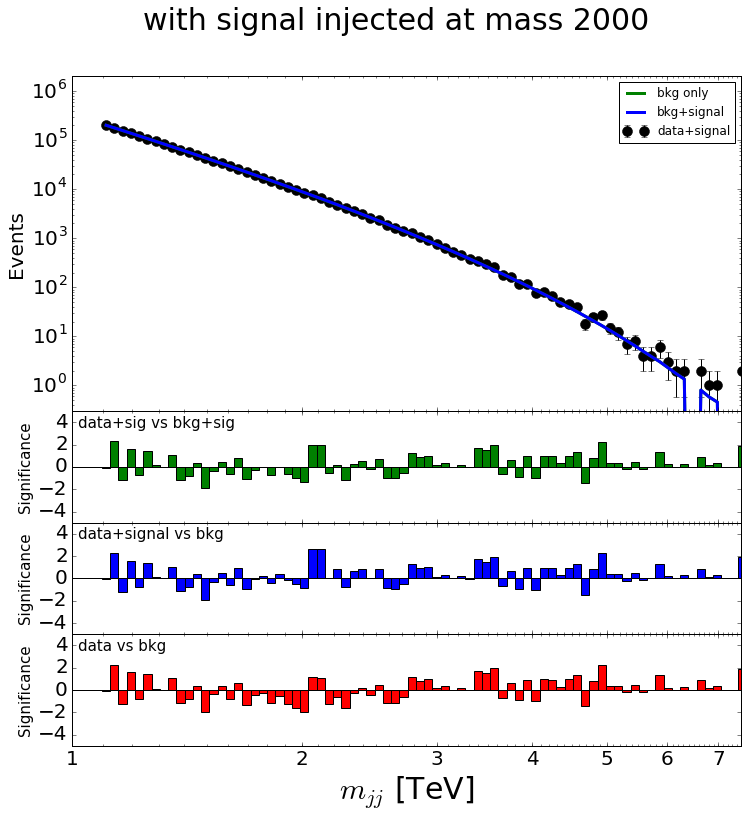

chi2 bkg+signal mu=0 93.5210923152
chi2 bkg+signal 93.5210923166


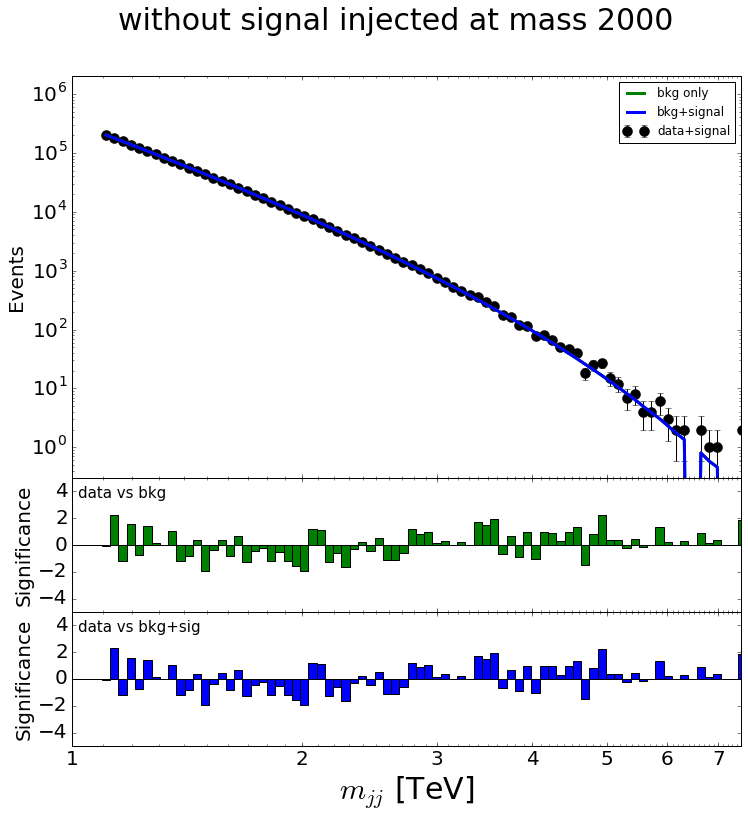

background + signal time: 6.60758709908
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600
5700
5800
5900
6000
6100
6200
6300
6400
6500
6600
6700
6800
6900
7000
7100
7200
7300
7400
7500
7600
7700
7800
7900
8000
8100
8200
8300
8400
8500
8600
8700
8800
8900
9000
9100
9200
9300
9400
9500
9600
9700
9800
9900
(750, 2500, 250)
0
background only time: 0.00227093696594
background only time: 0.0023090839386
SIGNAL STRENGTH NO SIGNAL 5.4518859427e-07
background + signal time: 0.0312330722809
SIGNAL STRENGTH WITH SIGNAL 0.845872471569
chi2 bkg+signal mu=0 92.892527553
chi2 bkg+signal 107.955264909
chi2 bkg+signal 93.5210878818


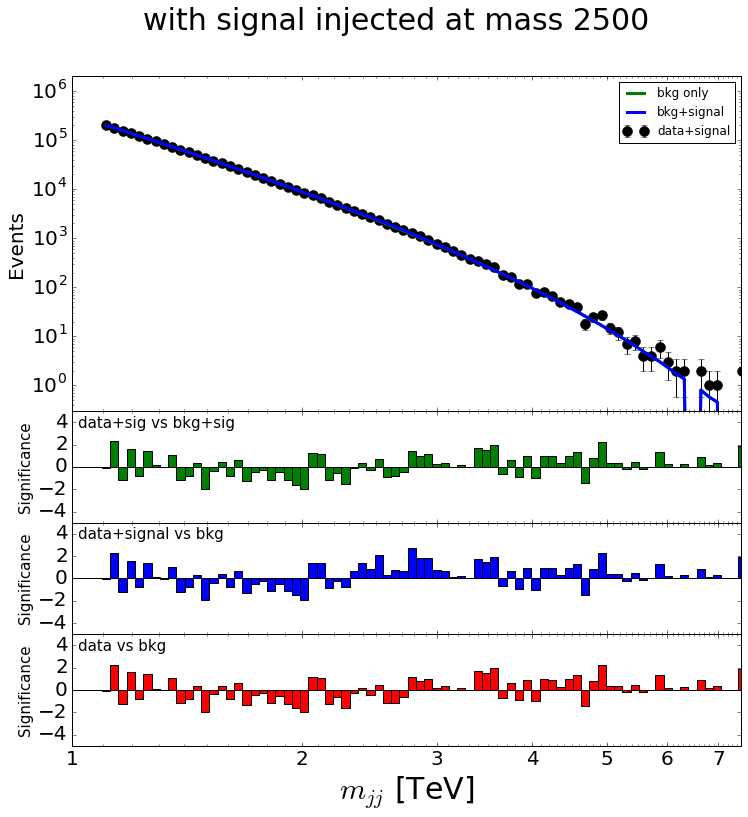

chi2 bkg+signal mu=0 93.5210923152
chi2 bkg+signal 93.5210951381


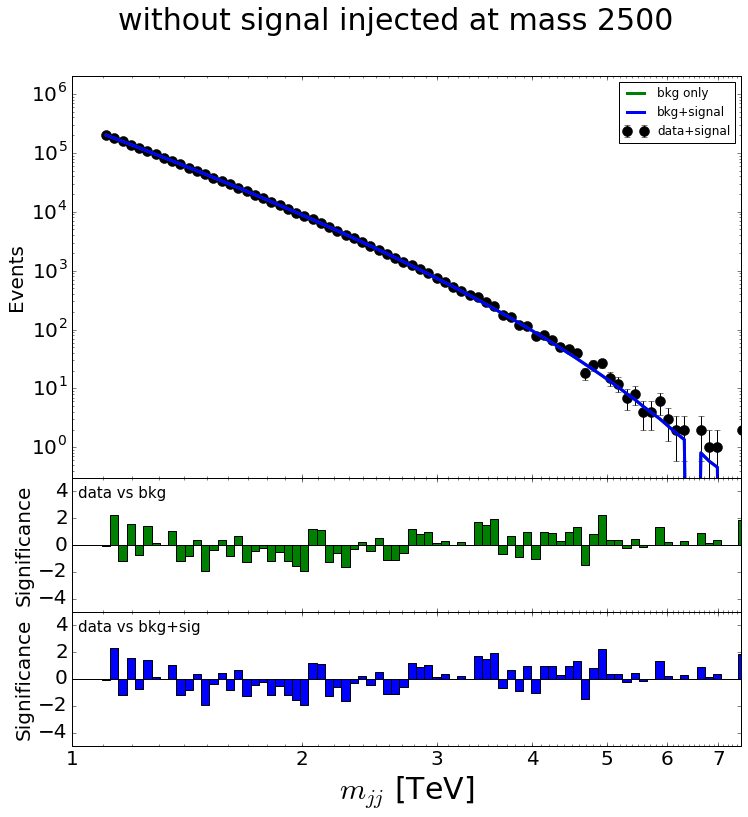

background + signal time: 6.52291417122
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600
5700
5800
5900
6000
6100
6200
6300
6400
6500
6600
6700
6800
6900
7000
7100
7200
7300
7400
7500
7600
7700
7800
7900
8000
8100
8200
8300
8400
8500
8600
8700
8800
8900
9000
9100
9200
9300
9400
9500
9600
9700
9800
9900
(500, 3000, 250)
0
background only time: 0.00242304801941
background only time: 0.00291609764099
SIGNAL STRENGTH NO SIGNAL 0.230144169284
background + signal time: 0.0337958335876
SIGNAL STRENGTH WITH SIGNAL 1.2325896814
chi2 bkg+signal mu=0 90.6743318524
chi2 bkg+signal 150.625297126
chi2 bkg+signal 93.5149339876


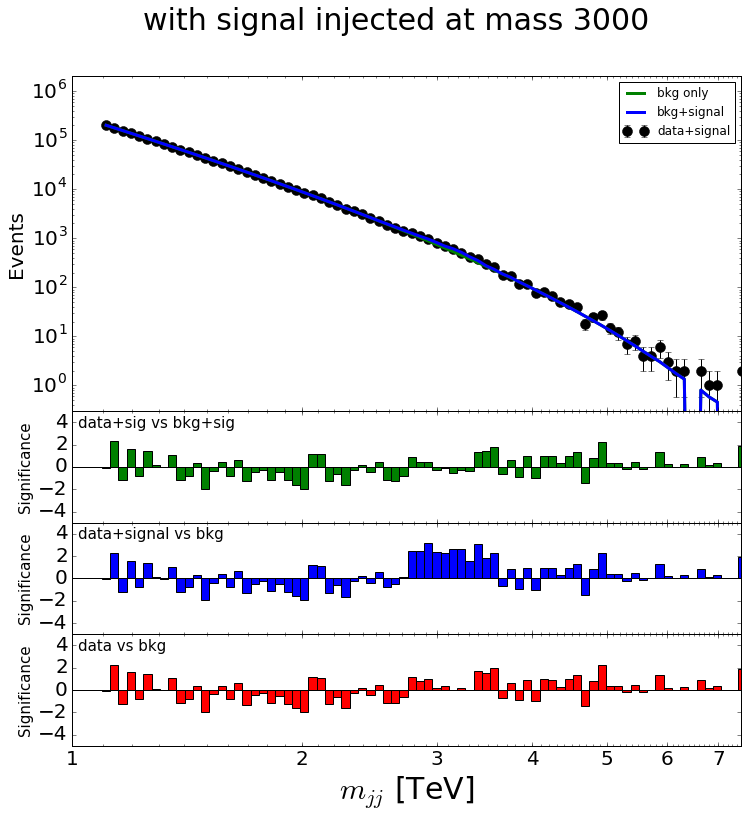

chi2 bkg+signal mu=0 93.5210923152
chi2 bkg+signal 91.1606293531


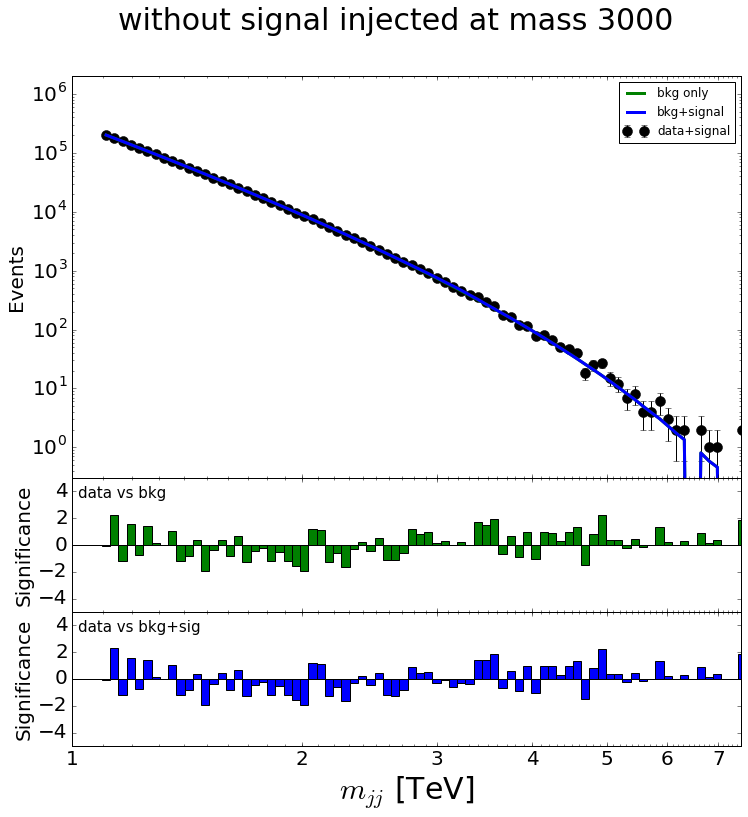

background + signal time: 6.28957986832
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600
5700
5800
5900
6000
6100
6200
6300
6400
6500
6600
6700
6800
6900
7000
7100
7200
7300
7400
7500
7600
7700
7800
7900
8000
8100
8200
8300
8400
8500
8600
8700
8800
8900
9000
9100
9200
9300
9400
9500
9600
9700
9800
9900
(200, 3500, 250)
0
background only time: 0.00294303894043
background only time: 0.00274085998535
SIGNAL STRENGTH NO SIGNAL 0.473566492004
background + signal time: 0.0292568206787
SIGNAL STRENGTH WITH SIGNAL 1.47699991503
chi2 bkg+signal mu=0 87.5490337948
chi2 bkg+signal 130.380201032
chi2 bkg+signal 93.5130392058


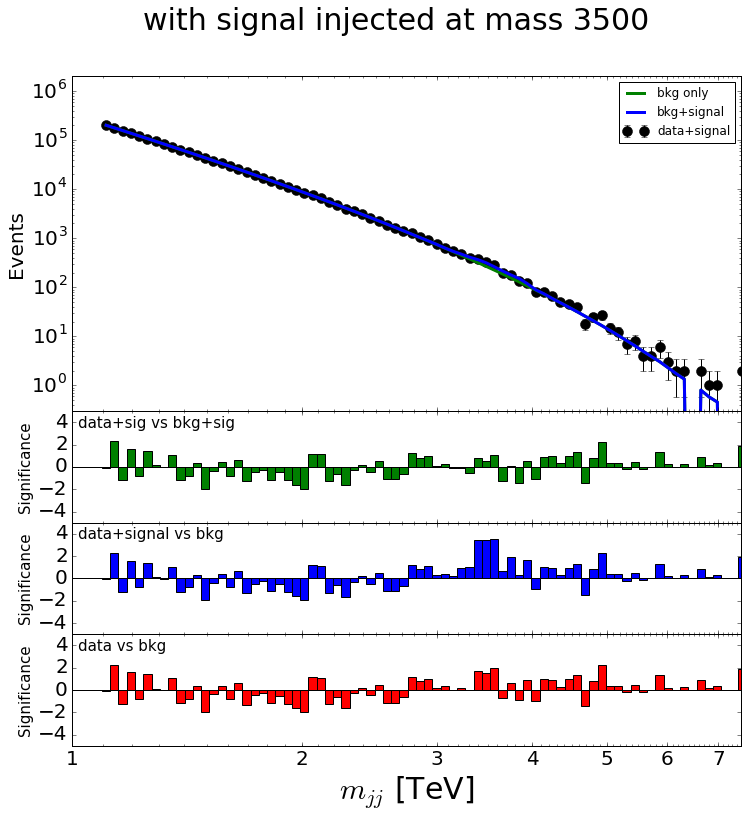

chi2 bkg+signal mu=0 93.5210923152
chi2 bkg+signal 88.2627431923


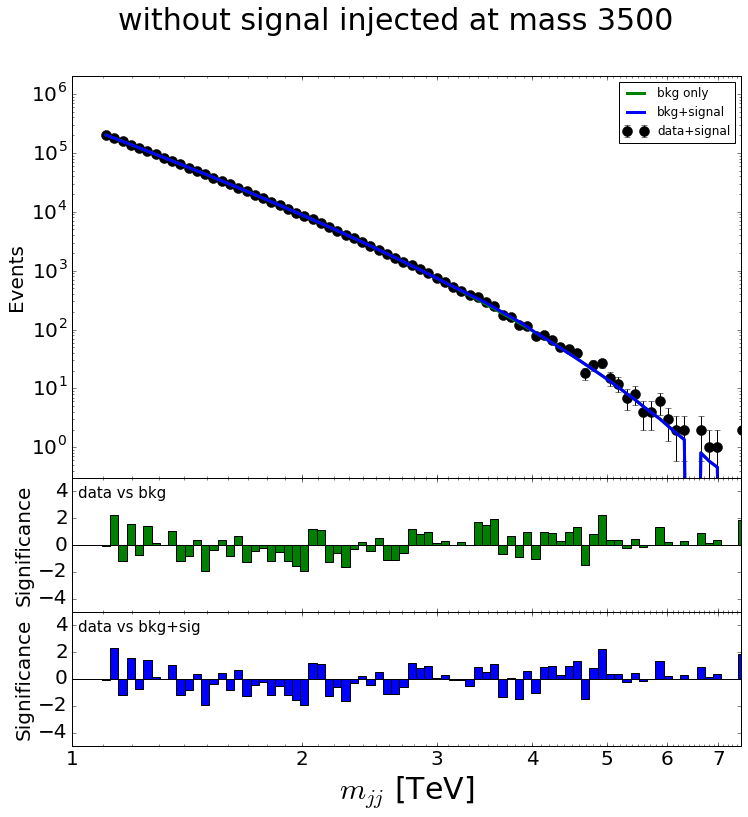

background + signal time: 6.48336791992
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600
5700
5800
5900
6000
6100
6200
6300
6400
6500
6600
6700
6800
6900
7000
7100
7200
7300
7400
7500
7600
7700
7800
7900
8000
8100
8200
8300
8400
8500
8600
8700
8800
8900
9000
9100
9200
9300
9400
9500
9600
9700
9800
9900
(100, 4000, 250)
0
background only time: 0.00236487388611
background only time: 0.00206279754639
SIGNAL STRENGTH NO SIGNAL 0.130655826514
background + signal time: 0.0408210754395
SIGNAL STRENGTH WITH SIGNAL 1.14563338818
chi2 bkg+signal mu=0 92.116334889
chi2 bkg+signal 108.511594528
chi2 bkg+signal 93.5117367616


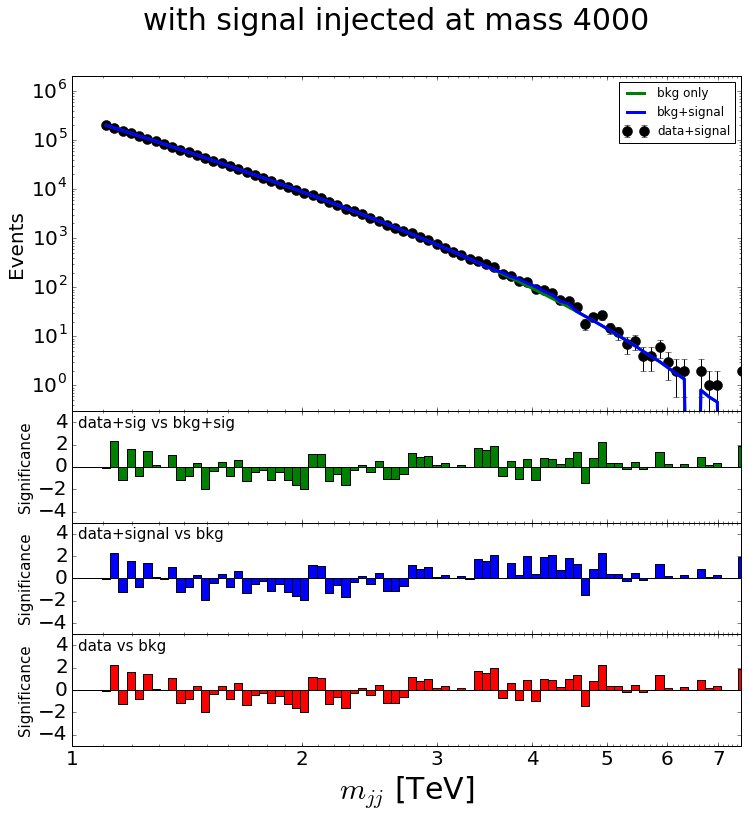

chi2 bkg+signal mu=0 93.5210923152
chi2 bkg+signal 92.9761648604


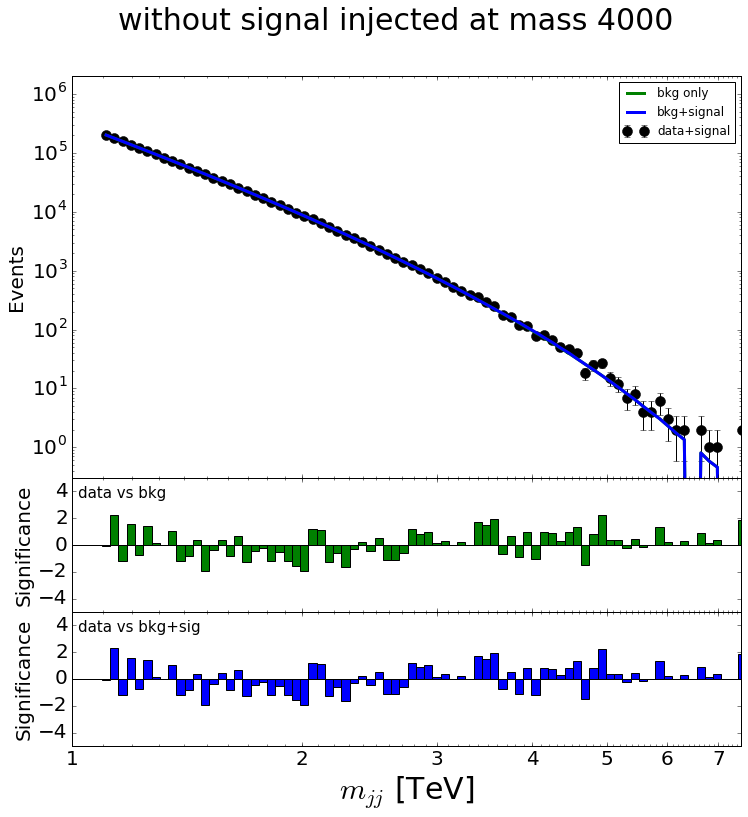

background + signal time: 6.0894010067
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600
5700
5800
5900
6000
6100
6200
6300
6400
6500
6600
6700
6800
6900
7000
7100
7200
7300
7400
7500
7600
7700
7800
7900
8000
8100
8200
8300
8400
8500
8600
8700
8800
8900
9000
9100
9200
9300
9400
9500
9600
9700
9800
9900
(75, 4500, 250)
0
background only time: 0.00236701965332
background only time: 0.00200700759888
SIGNAL STRENGTH NO SIGNAL 0.0694224718022
background + signal time: 0.041836977005
SIGNAL STRENGTH WITH SIGNAL 1.16367613664
chi2 bkg+signal mu=0 88.8367424602
chi2 bkg+signal 133.950181017
chi2 bkg+signal 93.5036070404


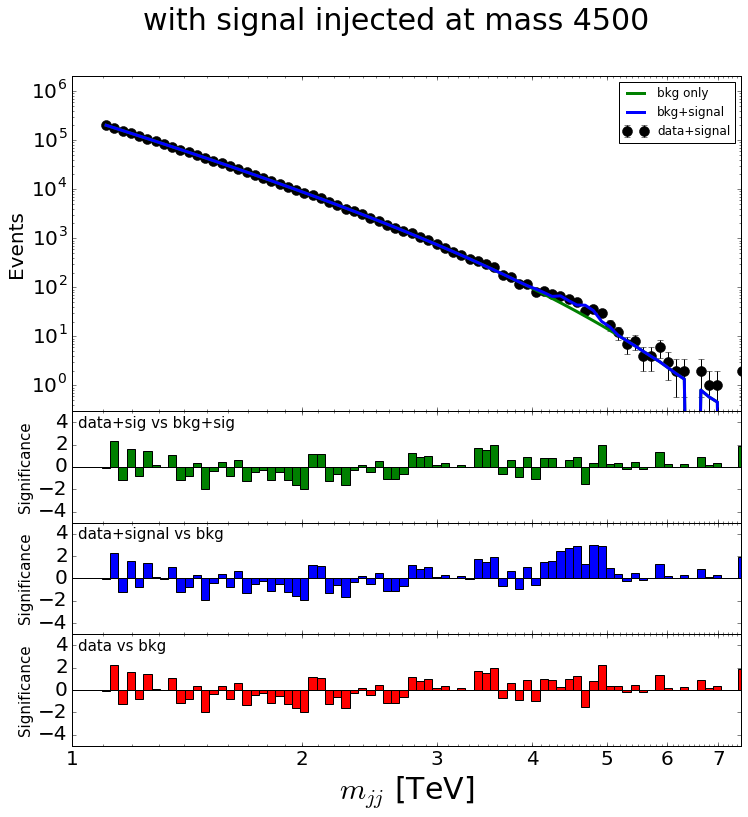

chi2 bkg+signal mu=0 93.5210923152
chi2 bkg+signal 92.5248009864


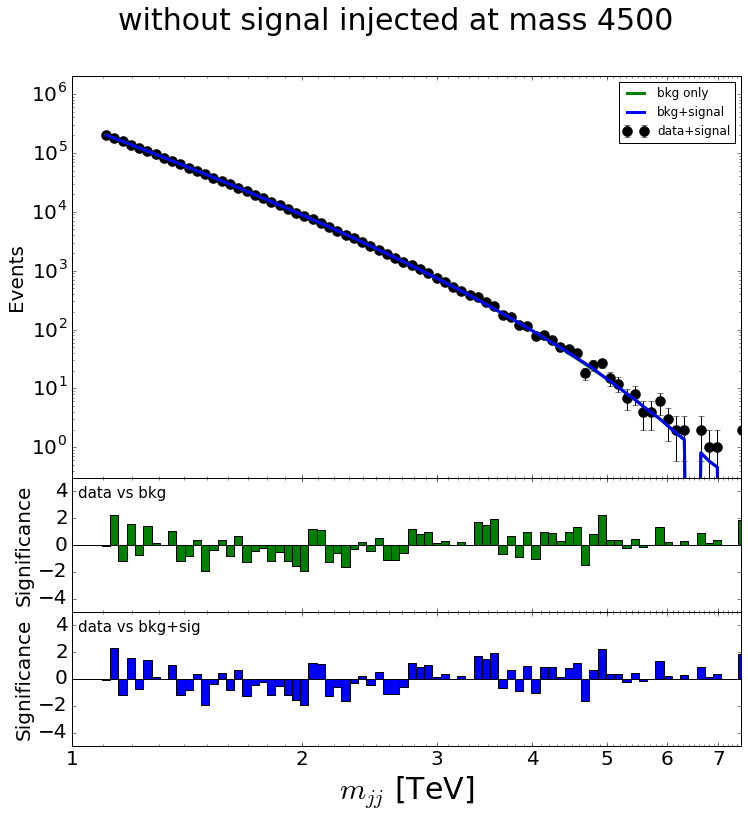

background + signal time: 6.10242700577
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600
5700
5800
5900
6000
6100
6200
6300
6400
6500
6600
6700
6800
6900
7000
7100
7200
7300
7400
7500
7600
7700
7800
7900
8000
8100
8200
8300
8400
8500
8600
8700
8800
8900
9000
9100
9200
9300
9400
9500
9600
9700
9800
9900
(50, 5000, 250)
0
background only time: 0.0022029876709
background only time: 0.00200605392456
SIGNAL STRENGTH NO SIGNAL 0.194180836932
background + signal time: 0.0266489982605
SIGNAL STRENGTH WITH SIGNAL 1.22326314437
chi2 bkg+signal mu=0 87.9747887922
chi2 bkg+signal 137.215449812
chi2 bkg+signal 93.4894367552


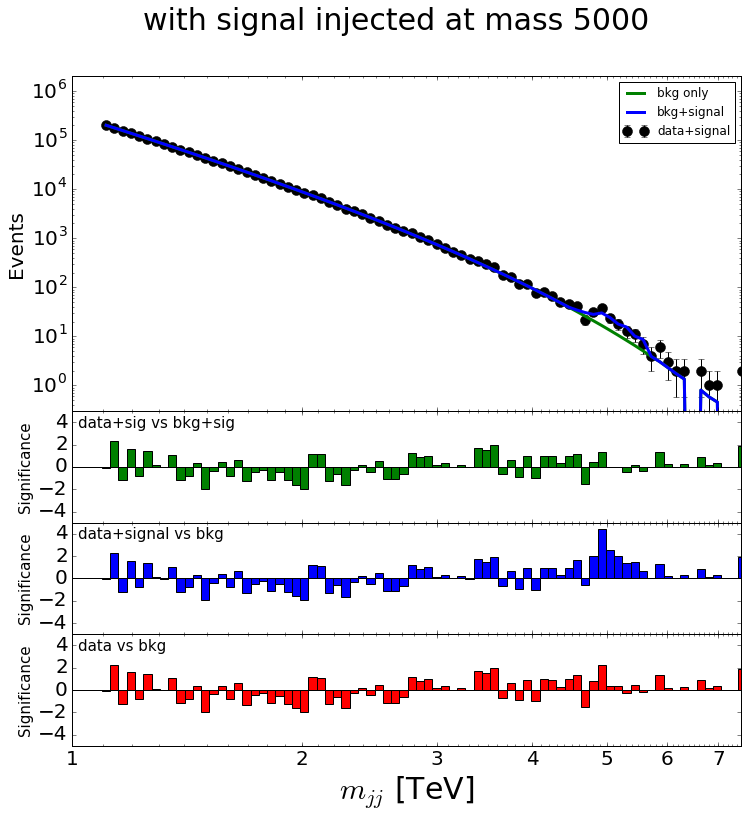

chi2 bkg+signal mu=0 93.5210923152
chi2 bkg+signal 90.4103457271


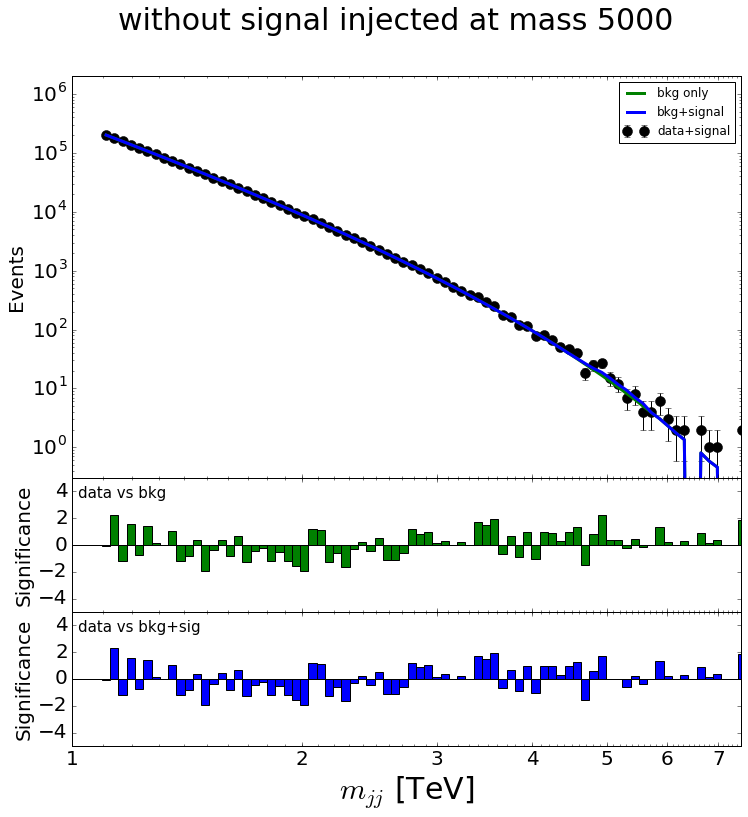

background + signal time: 5.98076319695
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600
5700
5800
5900
6000
6100
6200
6300
6400
6500
6600
6700
6800
6900
7000
7100
7200
7300
7400
7500
7600
7700
7800
7900
8000
8100
8200
8300
8400
8500
8600
8700
8800
8900
9000
9100
9200
9300
9400
9500
9600
9700
9800
9900
(30, 5500, 250)
0
background only time: 0.00219106674194
background only time: 0.00203704833984
SIGNAL STRENGTH NO SIGNAL 0.012548822199
background + signal time: 0.0365381240845
SIGNAL STRENGTH WITH SIGNAL 1.0571533683
chi2 bkg+signal mu=0 91.7294327384
chi2 bkg+signal 139.237019622
chi2 bkg+signal 93.4709771912


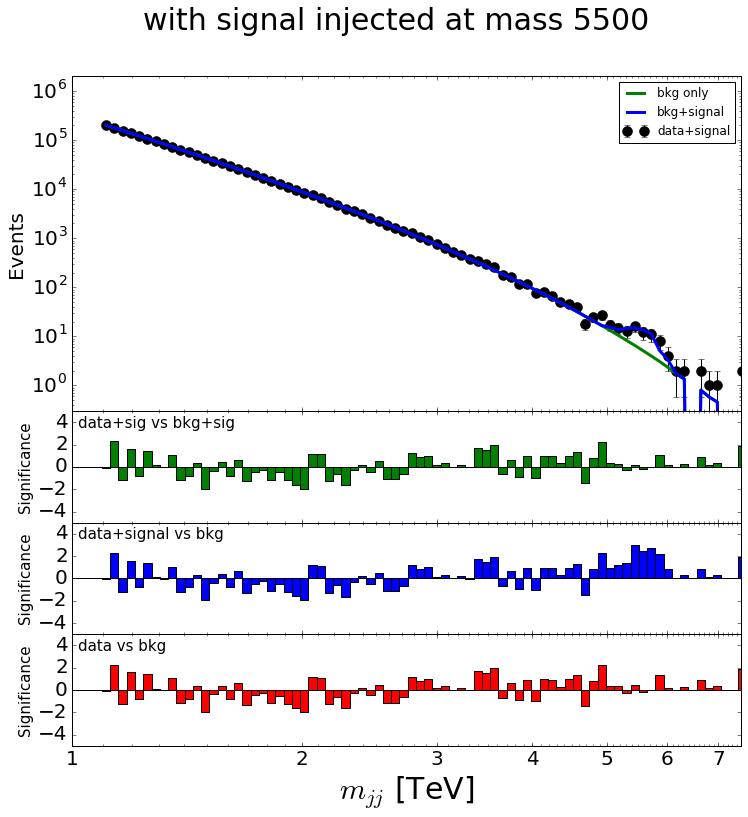

chi2 bkg+signal mu=0 93.5210923152
chi2 bkg+signal 93.4302798579


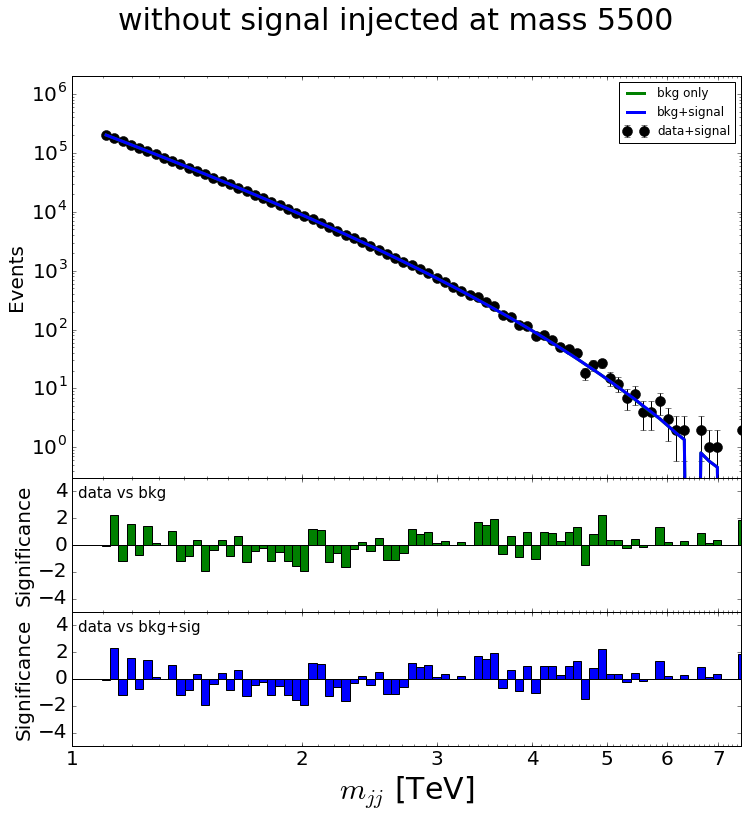

background + signal time: 7.25891208649
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600
5700
5800
5900
6000
6100
6200
6300
6400
6500
6600
6700
6800
6900
7000
7100
7200
7300
7400
7500
7600
7700
7800
7900
8000
8100
8200
8300
8400
8500
8600
8700
8800
8900
9000
9100
9200
9300
9400
9500
9600
9700
9800
9900
(25, 6000, 250)
0
background only time: 0.00222396850586
background only time: 0.00196290016174
SIGNAL STRENGTH NO SIGNAL 1.01562180888e-07
background + signal time: 0.0276799201965
SIGNAL STRENGTH WITH SIGNAL 1.09160726404
chi2 bkg+signal mu=0 91.4669817998
chi2 bkg+signal 148.934226696
chi2 bkg+signal 94.3400680152


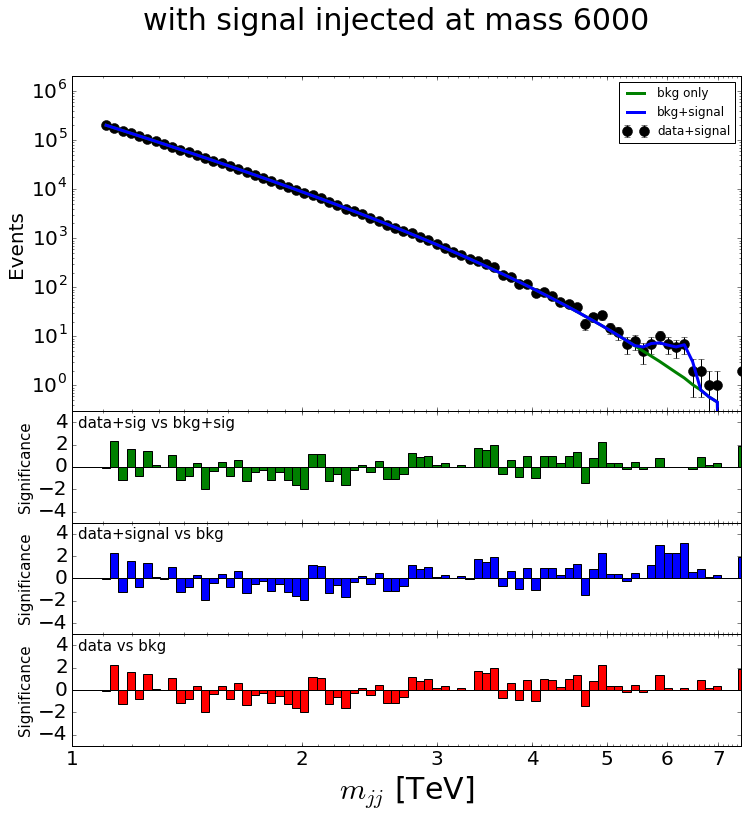

chi2 bkg+signal mu=0 93.5210923152
chi2 bkg+signal 93.521090264


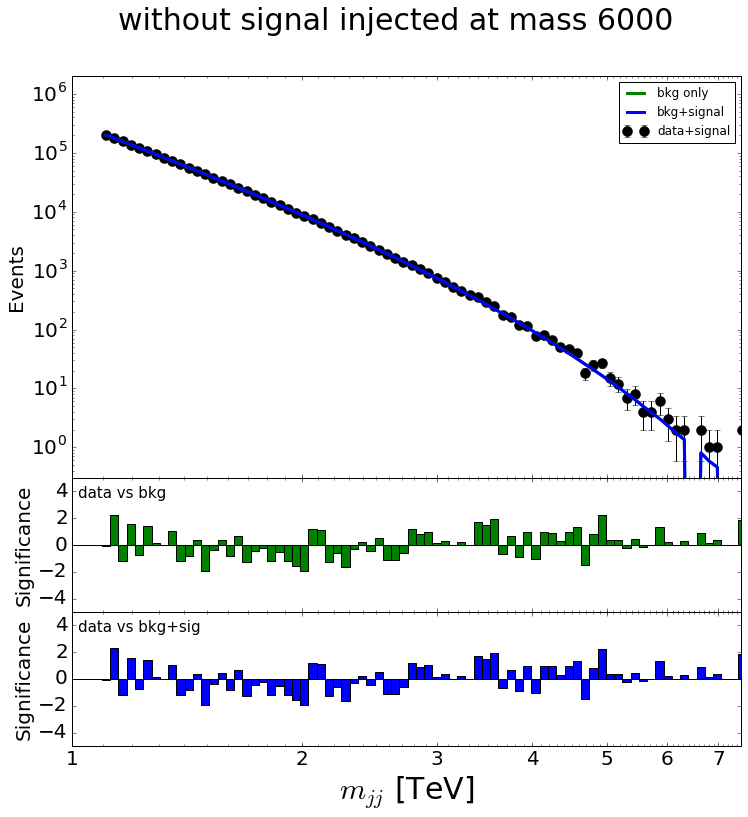

background + signal time: 5.96329188347
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600
5700
5800
5900
6000
6100
6200
6300
6400
6500
6600
6700
6800
6900
7000
7100
7200
7300
7400
7500
7600
7700
7800
7900
8000
8100
8200
8300
8400
8500
8600
8700
8800
8900
9000
9100
9200
9300
9400
9500
9600
9700
9800
9900
took 1.7085696478hours


In [38]:
btime=time.time()

LLHR_GP_noSignal={}
LLHR_GP_withSignal={}
for pSet in standardParamSets:
    n, m, w = pSet
    print pSet
    LLHR_GP_noSignal[m]=[]
    LLHR_GP_withSignal[m]=[]

    for itoy, toy in enumerate(toyData):
        if not itoy%100: 
            print itoy

        signalTemplate = np.random.poisson(np.round(sig_model(xbins, n, m, w)))
        dataPlusSignal = toy+signalTemplate
        Amp, lengthscale, p0, p1, p2 = best_fit_hyp 
        kernel = Kernel((Amp, lengthscale))
        
        #############################################################################
        #BACKGROUND ONLY FIT TO DATA ONLY
        if itoy==0:
            pgpb_stime = time.time()
        
        MAP_bkg, covGP_bkg, LLH_bkg = runGP(xbins, toy, kernel)
   
        if itoy==0:
            pgpb_etime = time.time()
            print "background only time:", pgpb_etime-pgpb_stime
        #############################################################################
        #BACKGROUND ONLY FIT TO DATA+SIGNAL ONLY
        if itoy==0:
            pgpb_stime = time.time()
            
        MAP_bkg_sd, covGP_bkg_sd, LLH_bkg_sd = runGP(xbins, dataPlusSignal, kernel)    
         
        if itoy==0:
            pgpb_etime = time.time()
            print "background only time:", pgpb_etime-pgpb_stime
        #############################################################################
        

        #############################################################################        
        #BACKGROUND+SIGNAL FIT GP
        if itoy==0:
            pgpsb_stime = time.time()

        lnProb = logLike_gp(xbins, toy, signalTemplate)
        minLLH, best_fit_gp = fit_gp(lnProb, False)
        if np.isinf(minLLH): continue
        signal_strength = best_fit_gp[0]

        MAP_sigbkg, covGP_sigbkg, LLH_sigbkg = runGP_sig(xbins, toy, signal_strength, signalTemplate, kernel)

        if itoy==0:
            print "SIGNAL STRENGTH NO SIGNAL", signal_strength
            pgpsb_etime = time.time()
            print "background + signal time:", pgpsb_etime - pgpsb_stime
        
        LLHR_GP_noSignal[m].append(-2*(LLH_bkg-LLH_sigbkg))
        #############################################################################    
            
        #BACKGROUND+SIGNAL FIT GP ON DATA+SIGNAL
        if itoy==0:
            pgpsb_sd_stime = time.time()

        lnProb = logLike_gp(xbins, dataPlusSignal, signalTemplate)
        minLLH, best_fit_gp = fit_gp(lnProb, False)
        if np.isinf(minLLH): continue
        signal_strength_sd = best_fit_gp[0]

        MAP_sigbkg_sd, covGP_sigbkg_sd, LLH_sigbkg_sd = runGP_sig(xbins, dataPlusSignal, signal_strength_sd, signalTemplate, kernel)


        if itoy==0:
            print "SIGNAL STRENGTH WITH SIGNAL", signal_strength_sd
            makePrettyPlots_sb(xbins, dataPlusSignal, toy, MAP_bkg_sd, MAP_sigbkg_sd, binEdges, "with signal injected at mass "+str(m), ymax = 2e6)
            makePrettyPlots_signal(xbins, toy, MAP_bkg, MAP_sigbkg, binEdges, "without signal injected at mass "+str(m), ymax = 2e6)
            pgpsb_etime = time.time()
            print "background + signal time:", pgpsb_etime - pgpsb_stime
        
        LLHR_GP_withSignal[m].append(-2*(LLH_bkg_sd-LLH_sigbkg_sd))


etime = time.time()
print "took "+str((etime-btime)/(60.*60.)) + "hours"  

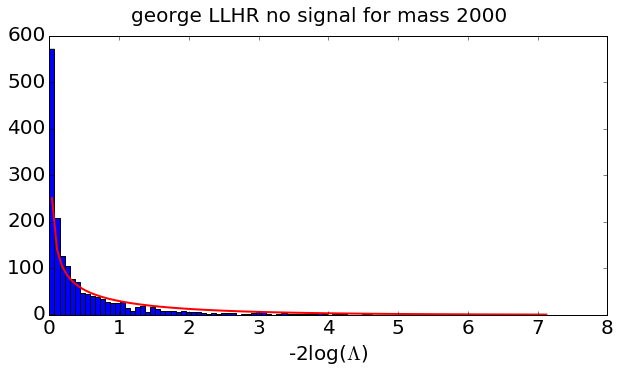

nc  [ 7.65228933]


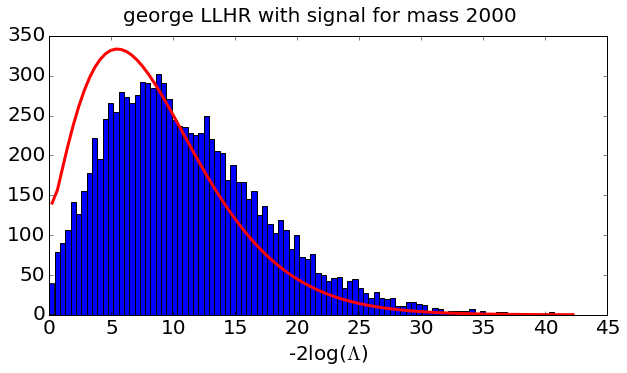

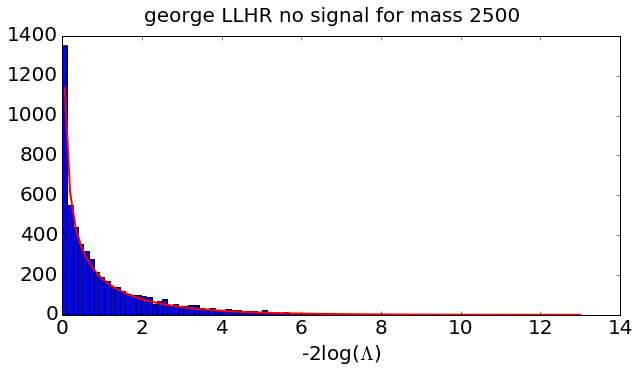

nc  [ 18.48185904]


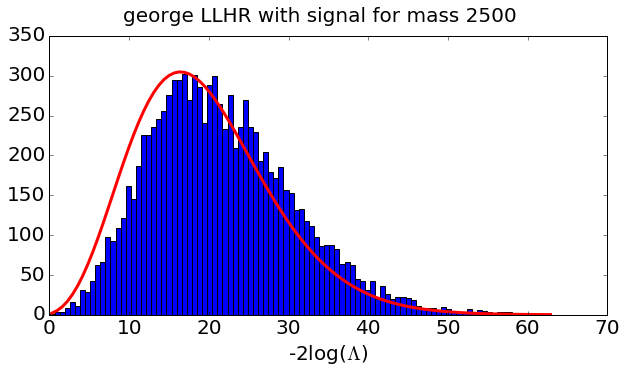

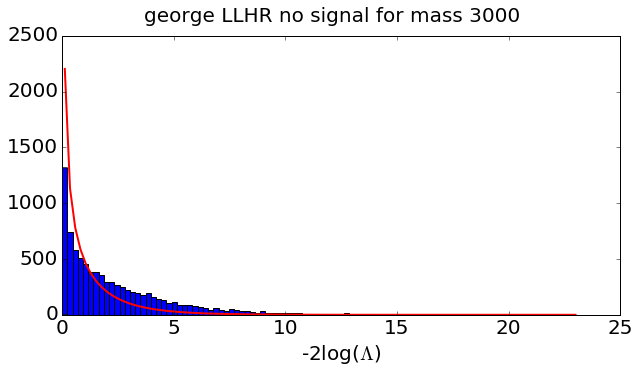

nc  [ 40.61937731]


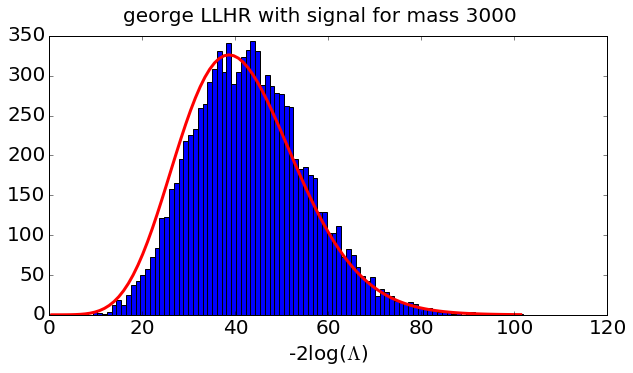

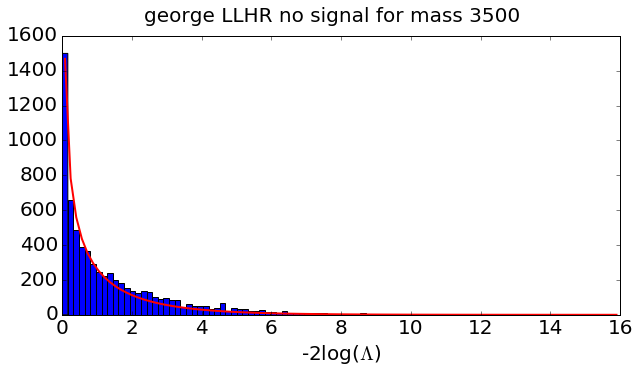

nc  [ 17.8370758]


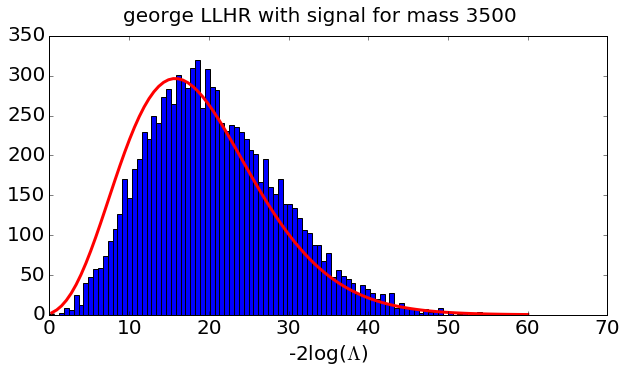

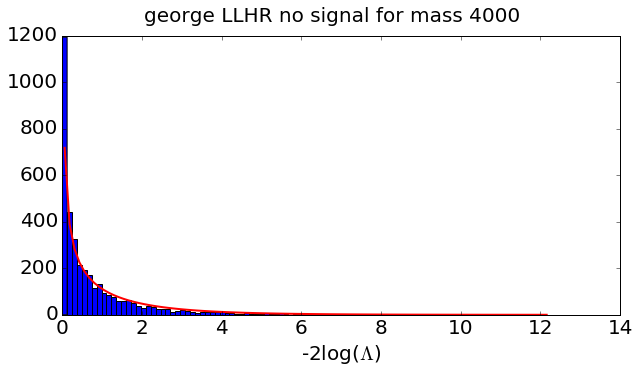

nc  [ 8.44754621]


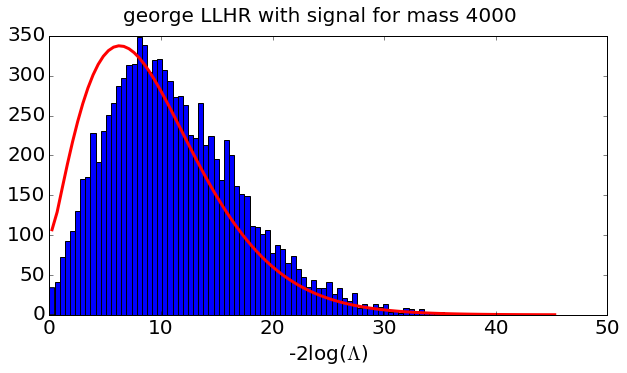

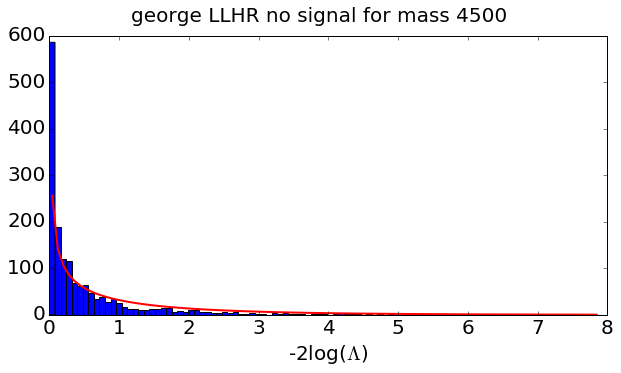

nc  [ 9.63873745]


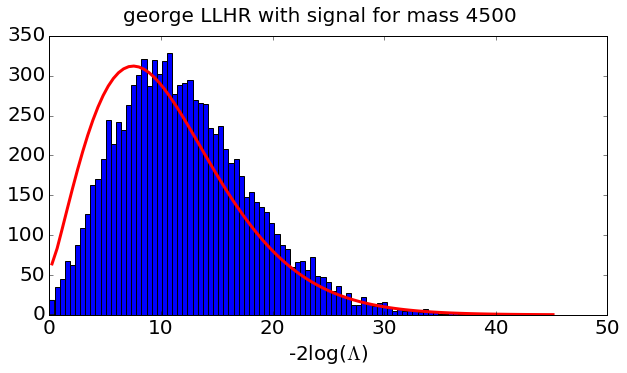

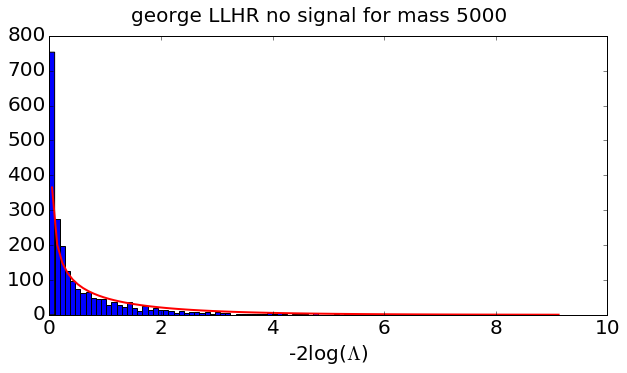

nc  [ 11.79364652]


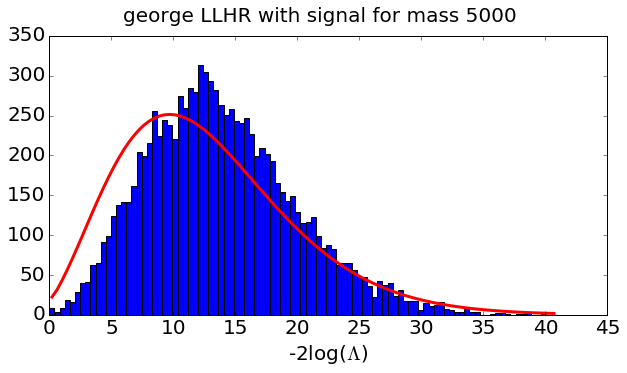

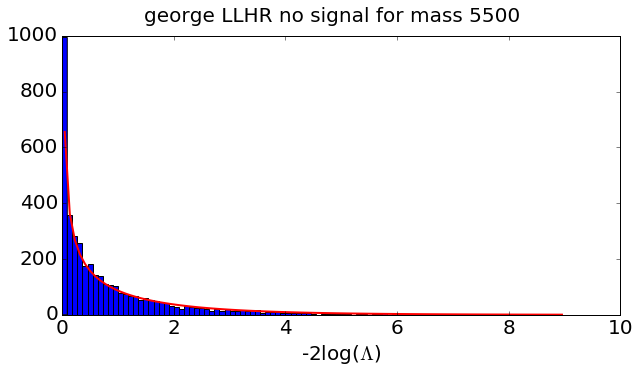

nc  [ 11.95289083]


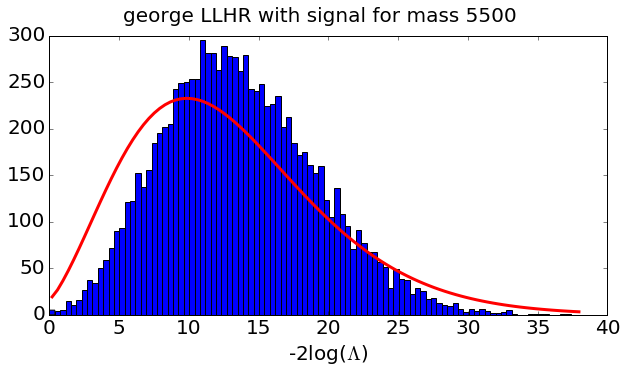

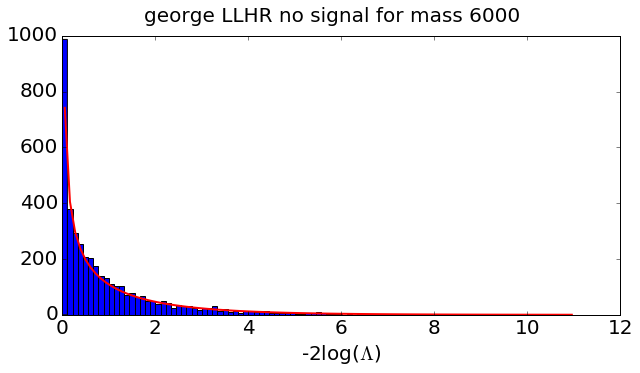

nc  [ 15.84866355]


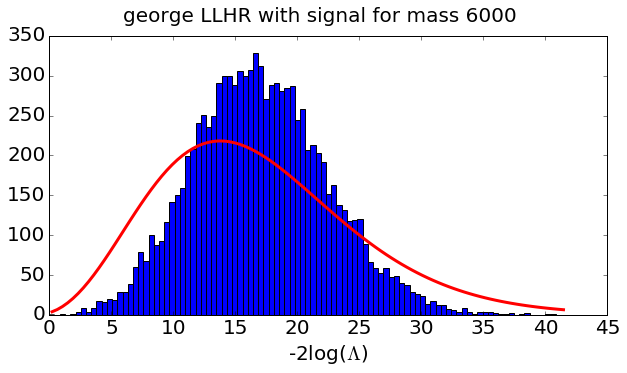

In [39]:
GP_meanLLHR_noSignal=[]
GP_meanLLHR_withSignal=[]
msignals = [standardParamSets[i][1] for i in range(len(standardParamSets))]
for m in msignals:
    gp_LLH_noSignal = [ll for ll in LLHR_GP_noSignal[m] if not (np.isinf(ll) or np.isnan(ll))]
    gp_LLH_withSignal = [ll for ll in LLHR_GP_withSignal[m] if not (np.isinf(ll) or np.isnan(ll))]
    
    
    GP_meanLLHR_noSignal.append([np.median(np.array(gp_LLH_noSignal)), np.std(np.array(gp_LLH_noSignal))])
    GP_meanLLHR_withSignal.append([np.median(np.array(gp_LLH_withSignal)), np.std(np.array(gp_LLH_withSignal))])

    label = "george LLHR no signal for mass "+str(int(m))
    makePrettyPlots_LLH(gp_LLH_noSignal, label, drawchi2=True, drawNCchi2=False, xname = r"-2log($\Lambda$)")

    label = "george LLHR with signal for mass "+str(int(m))
    makePrettyPlots_LLH(gp_LLH_withSignal, label, drawchi2=False, drawNCchi2=True, xname = r"-2log($\Lambda$)")

